# The best medicine for the patient - multiclass classification
This project seeks to predict the most suitable drug for a patient based on given information, utilizing Naive Bayes and Support Vector Machines (SVM) algorithms. The choice of these algorithms allows for a comparative analysis between a simple (Naive Bayes) and a more complex model (SVM), particularly on a small dataset. While SVM is well-regarded for its effectiveness in high-dimensional spaces and handling small-to-medium sized datasets, Naive Bayes, despite its simplicity and strong assumptions about feature independence, has been shown to perform reasonably well even on smaller datasets. Which algorithm will perform better?

#### Table of Contents:
1. [About the dataset](#about_the_dataset)


2. [Necessary imports](#necessary_imports)


3. [Exploratory Data Analysis](#exploratory_data_analysis)
    - &nbsp;&nbsp;&nbsp;&nbsp;3.1 [Understanding the dataset](#understanding_the_dataset)
    - &nbsp;&nbsp;&nbsp;&nbsp;3.2 [EDA for target variable](#eda_for_target_variable)


4. [Model Development](#model_development)
     - &nbsp;&nbsp;&nbsp;&nbsp;4.1 [Data preparation](#data_preparation)
     - &nbsp;&nbsp;&nbsp;&nbsp;4.2 [Support Vector Machine](#support_vector_machine)
     - &nbsp;&nbsp;&nbsp;&nbsp;4.2 [Naive Bayes](#naive_bayes)
         - &nbsp;&nbsp;&nbsp;&nbsp;4.2.1 [Gaussian Naive Bayes](#gaussian_bayes)
         - &nbsp;&nbsp;&nbsp;&nbsp;4.2.2 [Multinomial Naive Bayes](#multi_bayes)


5. [Results and Conclusion](#conclusion)


<a id='about_the_dataset'></a>
## 1. About the dataset

Source: https://www.kaggle.com/datasets/prathamtripathi/drug-classification

<ul>
  <li>Target Feature: Drug type</li>
    
  <li>Features:
    <ul>
      <li>Age</li>
      <li>Sex</li>
      <li>Blood Pressure Levels (BP)</li>
      <li>Cholesterol Levels</li>
      <li>Na to Potassium Ratio</li>
    </ul>
  </li>
</ul>


<a id='necessary_imports'></a>
## 2. Necessary imports

In [96]:
# import all the required libraries to work
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
from scipy.stats import shapiro, pearsonr, chi2_contingency, f_oneway
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, KBinsDiscretizer, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [97]:
# load the dataset
df = pd.read_csv("drug200.csv")

<a id='exploratory_data_analysis'></a>
## 3. Exploratory Data Analysis

First, the characteristics of the data need to be analyzed, including the distribution, data types, missing values, and overall data structure. Secondly, the data will be explored to determine its relationship with the target variable, identifying informative features and eliminating redundant ones.

<a id='understanding_the_dataset'></a>
### 3.1. Understanding the dataset

In [98]:
# first look at the data
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


There are 200 rows (samples) and 6 columns (5 features and 1 target variable). It can be observed that there are different data types.

In [99]:
# data types
df.dtypes

Age              int64
Sex             object
BP              object
Cholesterol     object
Na_to_K        float64
Drug            object
dtype: object

2 features are numerical (int/float) and 3 features are object (string) type, and target is also an object

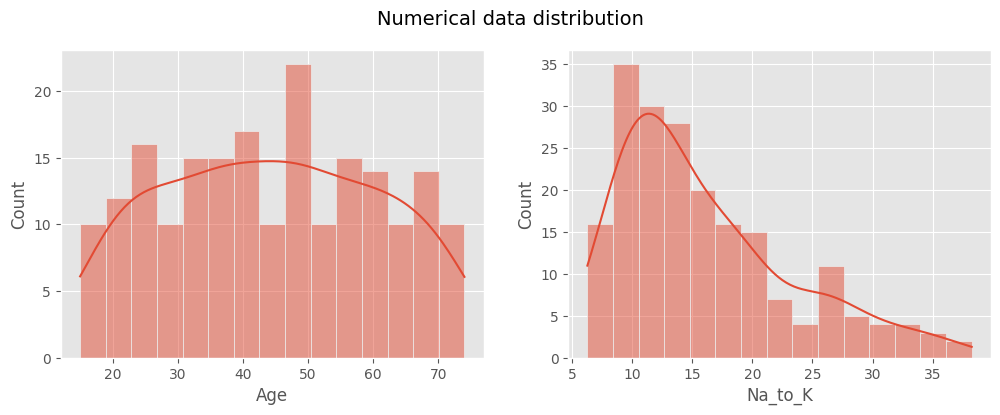

In [100]:
# characteristics of numerical data
fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.histplot(df["Age"],bins = 15,kde=True,ax=ax[0])
sns.histplot(df["Na_to_K"], bins=15,kde=True,ax=ax[1])
fig.suptitle("Numerical data distribution", fontsize=14)
plt.show()

Both numercial features can be classified and continuous, but it's hard to say if they are normally distributed.

The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.

In [101]:
# Shapiro-Wilk test of SciPy
print("Shapiro-Wilk test for age:",shapiro(df["Age"]))
print("Shapiro-Wilk test for Na_to_K:",shapiro(df["Na_to_K"]))

Shapiro-Wilk test for age: ShapiroResult(statistic=0.963939368724823, pvalue=5.408340075518936e-05)
Shapiro-Wilk test for Na_to_K: ShapiroResult(statistic=0.9018573760986328, pvalue=3.304816420524048e-10)


Statistic values of the Shapiro-Wilk test suggest that the data is normally distributed, but the p-value indicates that the test might not have been statistically significant. However, due to the small size of the dataset and very high Shapiro-Wilk test values, it can be tentatively assumed that the data follows a normal distribution. It is important to note that this analysis of the distribution does not consider grouping the values by the target variable, which could potentially affect the distributions. In the case that the data does not follow a normal distribution, Gaussian Naive Bayes may encounter some performance issues. However, given the context of this scenario, these issues are not expected to be significant.

In [102]:
# summary statistics for numerical features
df[["Age","Na_to_K"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,200.0,44.315000,16.544315,15.000,31.0000,45.0000,58.00,74.000
Na_to_K,200.0,16.084485,7.223956,6.269,10.4455,13.9365,19.38,38.247


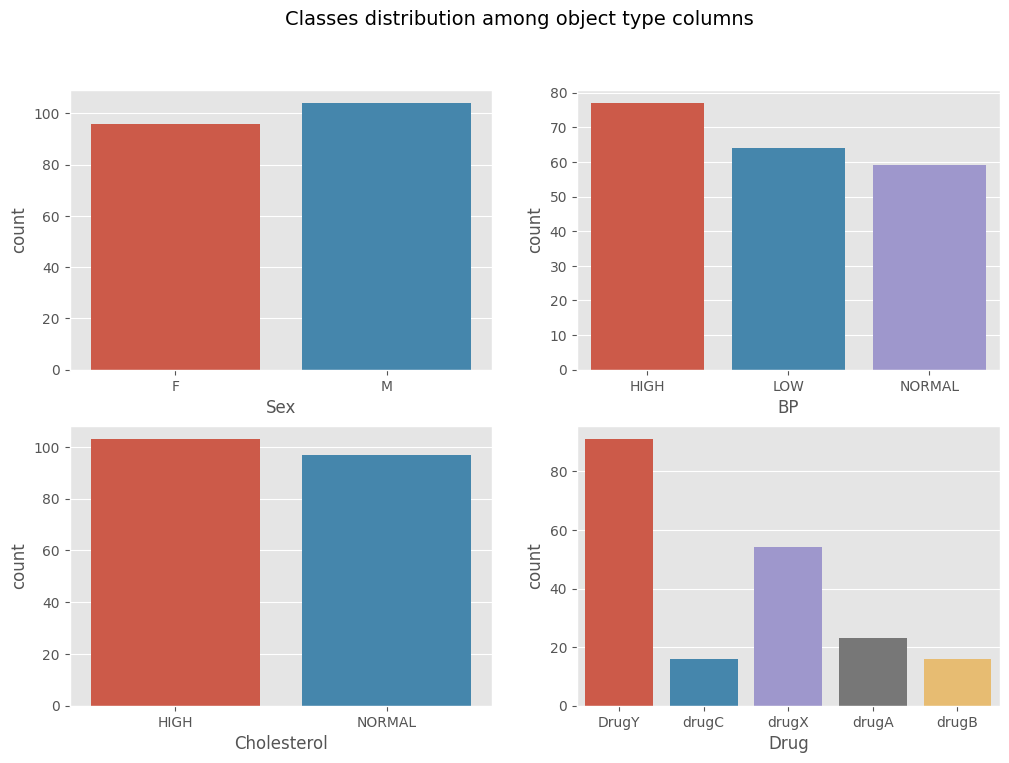

In [103]:
# characteristics of object type data and target variable
fig, ax = plt.subplots(2,2, figsize = (12,8))

sns.countplot(x=df["Sex"],ax=ax[0,0])
sns.countplot(x=df["BP"],ax=ax[0,1])
sns.countplot(x=df["Cholesterol"],ax=ax[1,0])
sns.countplot(x=df["Drug"],ax=ax[1,1])

fig.suptitle("Classes distribution among object type columns", fontsize=14)

plt.show()

In [104]:
# summary statistics for object columns
df[["Sex","BP","Cholesterol","Drug"]].describe().T

,count,unique,top,freq
Sex,200,2,M,104
BP,200,3,HIGH,77
Cholesterol,200,2,HIGH,103
Drug,200,5,DrugY,91


Based on distribution and class names, the objects features are:
- Categorical ordinal: BP, Cholesterol
- Categorical nominal: Sex

And the target is multiclass classification problem

The distribution of features is balanced, unlike the target, which is biased towards DrugY and DrugX. Additionally, an inconsistent format of the target variable naming can be observed, where DrugY starts with a capital letter while the rest start with small letters.

In [105]:
# fixing the format in target variable
df["Drug"].replace({"DrugY":"drugY"},inplace=True)

In [106]:
# missing values in the dataset
df.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

There are no missing values

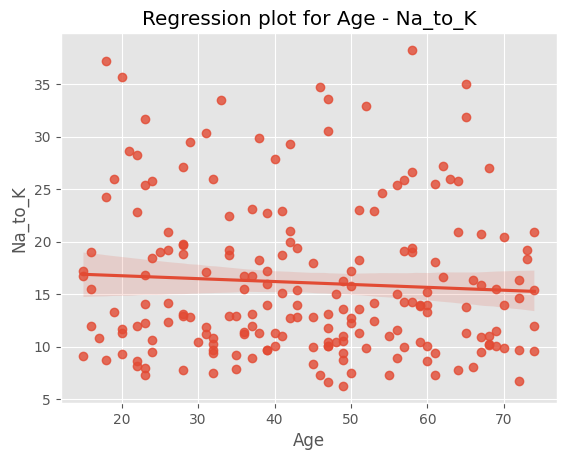

In [107]:
# examining the relationship between continuous features
sns.regplot(x=df["Age"],y=df["Na_to_K"])
plt.title("Regression plot for Age - Na_to_K")
plt.show()

In [108]:
# pearson correlation with p-value
pearsonr(df["Age"],df["Na_to_K"])

(-0.0631194972677259, 0.3745756399034559)

There is no linear correlation between continuous featuers. Correlation coeficient is very close to 0 and p-value is large.

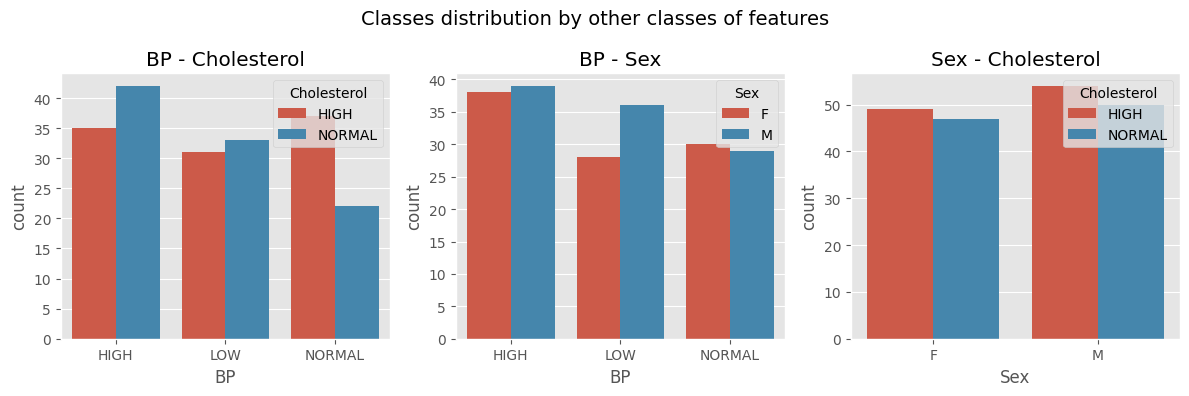

In [109]:
# examining the relationship between categorical features
fig,ax = plt.subplots(1,3,figsize=(12,4))
sns.countplot(x=df["BP"],hue=df["Cholesterol"],ax=ax[0])
ax[0].title.set_text("BP - Cholesterol")
sns.countplot(x=df["BP"],hue=df["Sex"],ax=ax[1])
ax[1].title.set_text("BP - Sex")
sns.countplot(x=df["Sex"],hue=df["Cholesterol"],ax=ax[2])
ax[2].title.set_text("Sex - Cholesterol")

fig.suptitle("Classes distribution by other classes of features", fontsize=14)
plt.tight_layout()

In [110]:
# chi-squared test 
bp_chol_value, bp_chol_p = chi2_contingency(pd.crosstab(index=df["BP"],columns=df["Cholesterol"]))[0:2]
bp_sex_value, bp_sex_p = chi2_contingency(pd.crosstab(index=df["BP"],columns=df["Sex"]))[0:2]
sex_chol_value, sex_chol_p = chi2_contingency(pd.crosstab(index=df["Sex"],columns=df["Cholesterol"]))[0:2]

print(f"Chi2 for BP - Cholersterol: stat: {bp_chol_value}, p-value: {bp_chol_p}")
print(f"Chi2 for BP - Sex: stat: {bp_sex_value}, p-value: {bp_sex_p}")
print(f"Chi2 for Sex - Cholersterol: stat: {sex_chol_value}, p-value: {sex_chol_p}")

Chi2 for BP - Cholersterol: stat: 4.33632565148387, p-value: 0.11438757389420079
Chi2 for BP - Sex: stat: 0.7110738837433747, p-value: 0.7007970548859668
Chi2 for Sex - Cholersterol: stat: 0.0, p-value: 1.0


Categorical features do not affect each other. P-values are really large and chi2 stats values are mostly low.

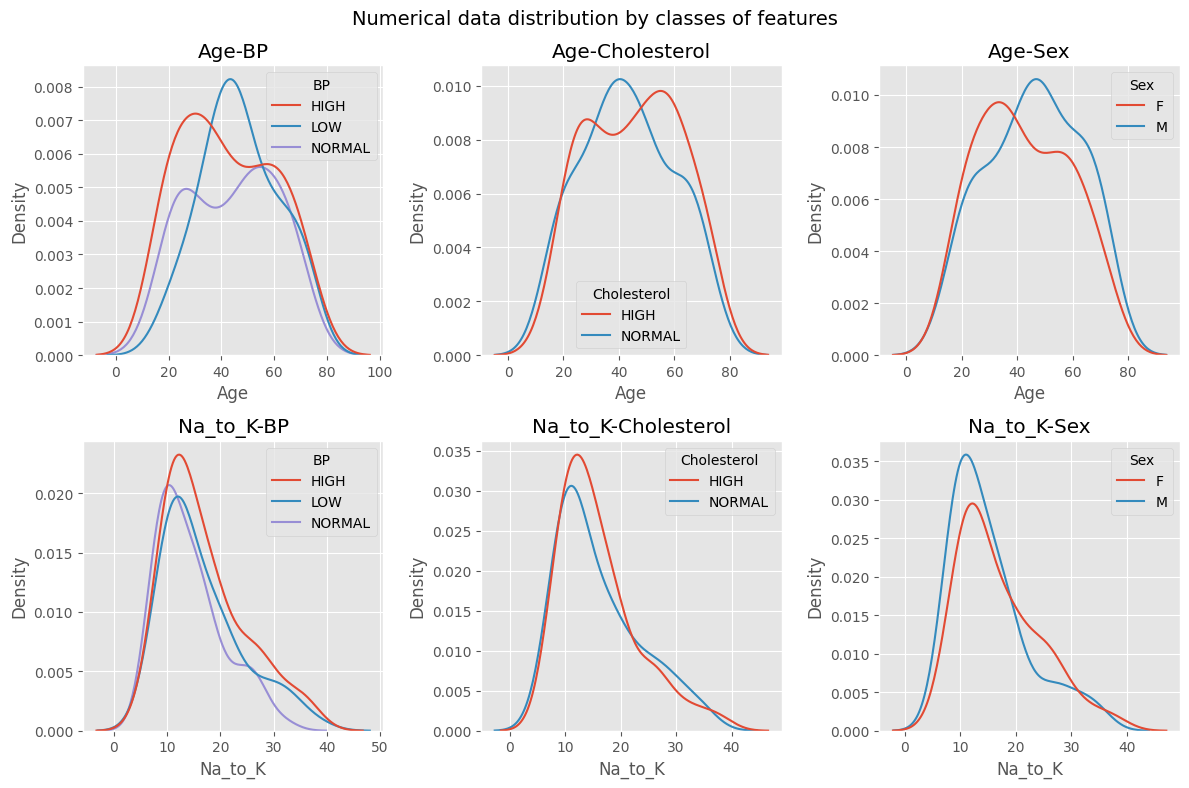

In [111]:
# examining relationships between continuous - categorical features
fig, ax = plt.subplots(2,3, figsize=(12,8))

x = -1

for continuous in ["Age","Na_to_K"]:
    y = -1
    x+=1
    for categorical in ["BP","Cholesterol","Sex"]:
        y+=1
        sns.kdeplot(x=df[continuous],hue = df[categorical],ax = ax[x,y])
        ax[x,y].title.set_text(f"{continuous}-{categorical}")
        
fig.suptitle("Numerical data distribution by classes of features", fontsize=14)        
plt.tight_layout()        

In [112]:
# ANOVA test
for continuous in ["Age","Na_to_K"]:
    for categorical in ["BP","Cholesterol","Sex"]:
        groups = []
        for class_ in df[categorical].unique():
            groups.append(df.loc[df[categorical] == class_,continuous]) 
        anova = f_oneway(*groups)  
        print(f"ANOVA test for {continuous} - {categorical}: stat: {anova[0]}, p-value: {anova[1]}")    

ANOVA test for Age - BP: stat: 1.4847404821324424, p-value: 0.22908514042581188
ANOVA test for Age - Cholesterol: stat: 0.9261725603260283, p-value: 0.33703329251590675
ANOVA test for Age - Sex: stat: 2.082778153577422, p-value: 0.1505490352727322
ANOVA test for Na_to_K - BP: stat: 2.555820797543222, p-value: 0.08020054490788678
ANOVA test for Na_to_K - Cholesterol: stat: 0.019803769448309666, p-value: 0.8882295724218179
ANOVA test for Na_to_K - Sex: stat: 3.143291008745802, p-value: 0.07777729010724369


Some statistics show that there is a difference, but due to large p-values related to all of them we can't say that these are statistically significant, so we can't reject null hypothesis stating that "There is no differene between groups". And looking on the graphs it looks like these differences are just random.

Conclusion: features are independent.

#### Summary of dataset characteristics:
- It is a tiny dataset containing only 200 rows and 6 columns
- The datatypes of features are mixed, continuous and categorical ordinal and nominal
- The distribtuion of categorical features is balanced and the distribution of continuous features is approximately normal
- There are no missing values in the dataset
- The features are completly independent

<a id='eda_for_target_variable'></a>
### 3.2. EDA for target variable

Exploring if features show any pattern/relationship with target variable, to decide if they are usefull in predicting the output.

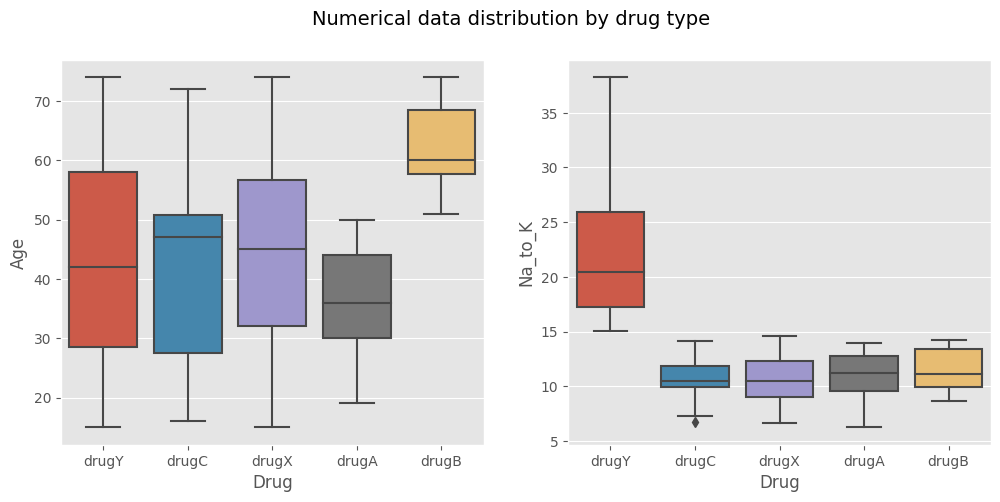

In [113]:
# continuous features and target
fig, ax = plt.subplots(1,2,figsize=(12,5))

sns.boxplot(y=df["Age"],x=df["Drug"],orient="v",ax=ax[0])
sns.boxplot(y=df["Na_to_K"],x=df["Drug"],orient="v",ax=ax[1])

fig.suptitle("Numerical data distribution by drug type", fontsize=14) 

plt.show()

At first look it seems pretty unsure if these continuous features show significant impact on the output. For "Age" feature only impact on drugB can be seen and for "Na_to_K" feature there is only significant impact on drugY. Because of this it can't be strictly said that these features will be more helpful or more harmful for the predictions. Notice that skewness in feature Na_to_K is explained here, distribtuion in group drugY mainly causes it.

In [114]:
# ANOVA test
for feature in ["Age","Na_to_K"]:
    groups = []
    for drug in df["Drug"].unique():
        groups.append(df.loc[df["Drug"] == drug,feature])
    anova = f_oneway(*groups)    
    print(f"ANOVA test for {feature} - Drug: stat: {anova[0]}, p-value: {anova[1]}")          

ANOVA test for Age - Drug: stat: 7.210544266570636, p-value: 1.956098104622817e-05
ANOVA test for Na_to_K - Drug: stat: 85.61135649670533, p-value: 7.429679925438015e-42


ANOVA test suggests that the difference between distribution of "Age" and "Na_to_K" is statistically significant, it's for sure caused my the outstanding drugs B and Y. Well still, it might either informative for the model or introduce bias due to lack of pattern in rest of the drugs. These features will be both included and excluded during model development, and the performance will be evaluated.

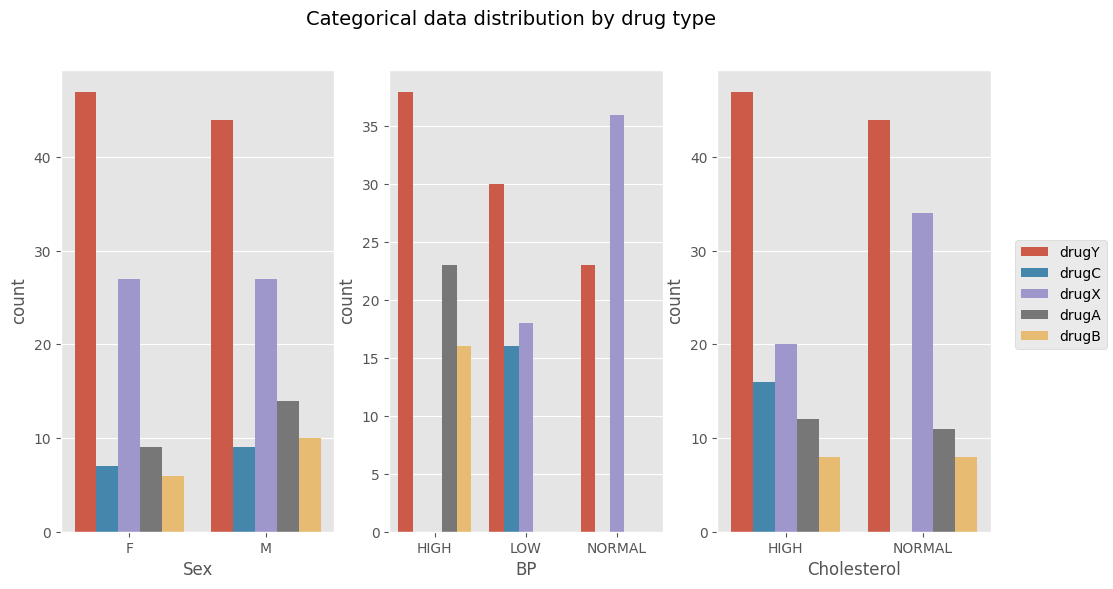

In [115]:
# categorical features and target

fig, ax = plt.subplots(1,3, figsize = (12,6))


sns.countplot(x=df["Sex"],hue=df["Drug"],ax=ax[0])
sns.countplot(x=df["BP"],hue=df["Drug"],ax=ax[1])
sns.countplot(x=df["Cholesterol"],hue=df["Drug"],ax=ax[2])

ax[0].get_legend().remove()
ax[1].get_legend().remove()
ax[2].get_legend().remove()


handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

fig.suptitle("Categorical data distribution by drug type", fontsize=14)

plt.show()


- Sex: distribution looks balanced
- BP: 
 - HIGH: drugC and drugX are absent, also this is the only class where drugA and drugB appear and drugY has most its instances here
 - LOW: drugA and drugB are absent, also this is the only class where drugC appears
 - NORMAL: drugC, drugA and drugB ale absent, also drugX has huge chunk of it's distribution here
- Cholesterol: overall distribution looks balanced for all drugs except drugC which appears only in class HIGH

BP feature seems most informative. Cholesterol feature also provides some information and Sex feature is probably useless.
These features will be futher examined using Chi-squared test.

In [116]:
chi_sex = chi2_contingency(pd.crosstab(df["Sex"],df["Drug"]))
chi_bp = chi2_contingency(pd.crosstab(df["BP"],df["Drug"]))
chi_chol = chi2_contingency(pd.crosstab(df["Cholesterol"],df["Drug"]))

print(f"Chi2 for Sex - Drug: stat: {chi_sex[0]}, p-value: {chi_sex[1]}")
print(f"Chi2 for BP - Drug: stat: {chi_bp[0]}, p-value: {chi_bp[1]}")
print(f"Chi2 for Cholesterol - Drug: stat: {chi_chol[0]}, p-value: {chi_chol[1]}")

Chi2 for Sex - Drug: stat: 2.119248418109203, p-value: 0.7138369773987128
Chi2 for BP - Drug: stat: 143.23287184969993, p-value: 5.041733414466518e-27
Chi2 for Cholesterol - Drug: stat: 19.609657681313468, p-value: 0.0005962588389856516


As expected, the sex feature may show a Chi-squared statistic above 0, but the p-value is so large that it suggests the score is meaningless. Furthermore, as observed earlier, the blood pressure (BP) feature is the most informative, with the highest statistical value and a very small p-value. The cholesterol feature also demonstrates a varying distribution between the output variable, but this may be attributed to the previously observed distribution of drugC.

Now after gaining very comprehensive knowlege about all features, it's worth to examine more complex patterns, see if combinations of features like Age grouped by BP show some new relationship with the target. Of course such exhaustive analysis might not be necessary but in case of such small dataset it is not a problem.

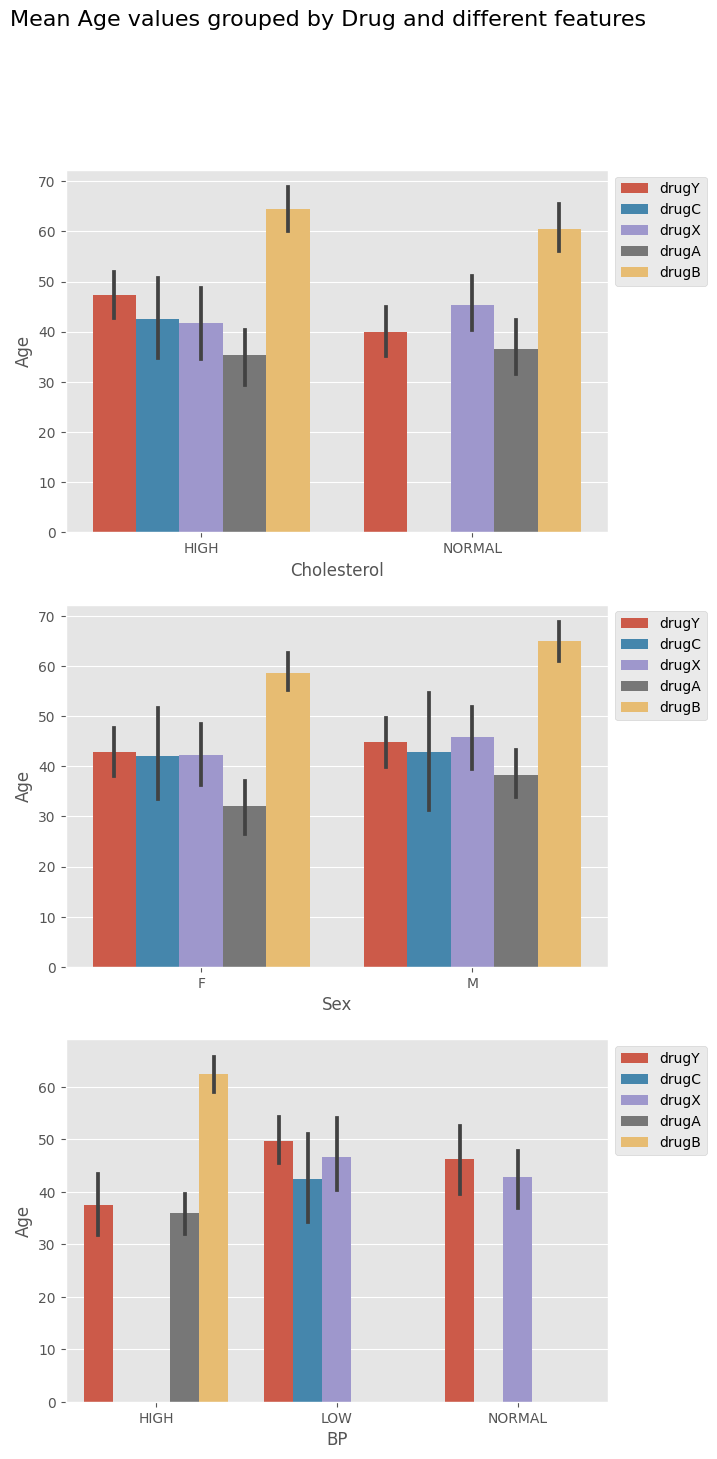

In [117]:
# Mean Age values grouped by Drug and different features
fig,ax = plt.subplots(3,1,figsize = (7,16))

sns.barplot(x=df["Cholesterol"],y=df["Age"],hue=df["Drug"],ax=ax[0])
ax[0].legend(bbox_to_anchor=(1, 1))

sns.barplot(x=df["Sex"],y=df["Age"],hue=df["Drug"],ax=ax[1])
ax[1].legend(bbox_to_anchor=(1, 1))

sns.barplot(x=df["BP"],y=df["Age"],hue=df["Drug"],ax=ax[2])
ax[2].legend(bbox_to_anchor=(1, 1))
          
                             
fig.suptitle("Mean Age values grouped by Drug and different features", fontsize=16) 

                           
plt.show()

No new pattern emerged, drugB has consistently highest Age mean, as it was observed previously and besides that rest of drugs have similar means between BP classes.

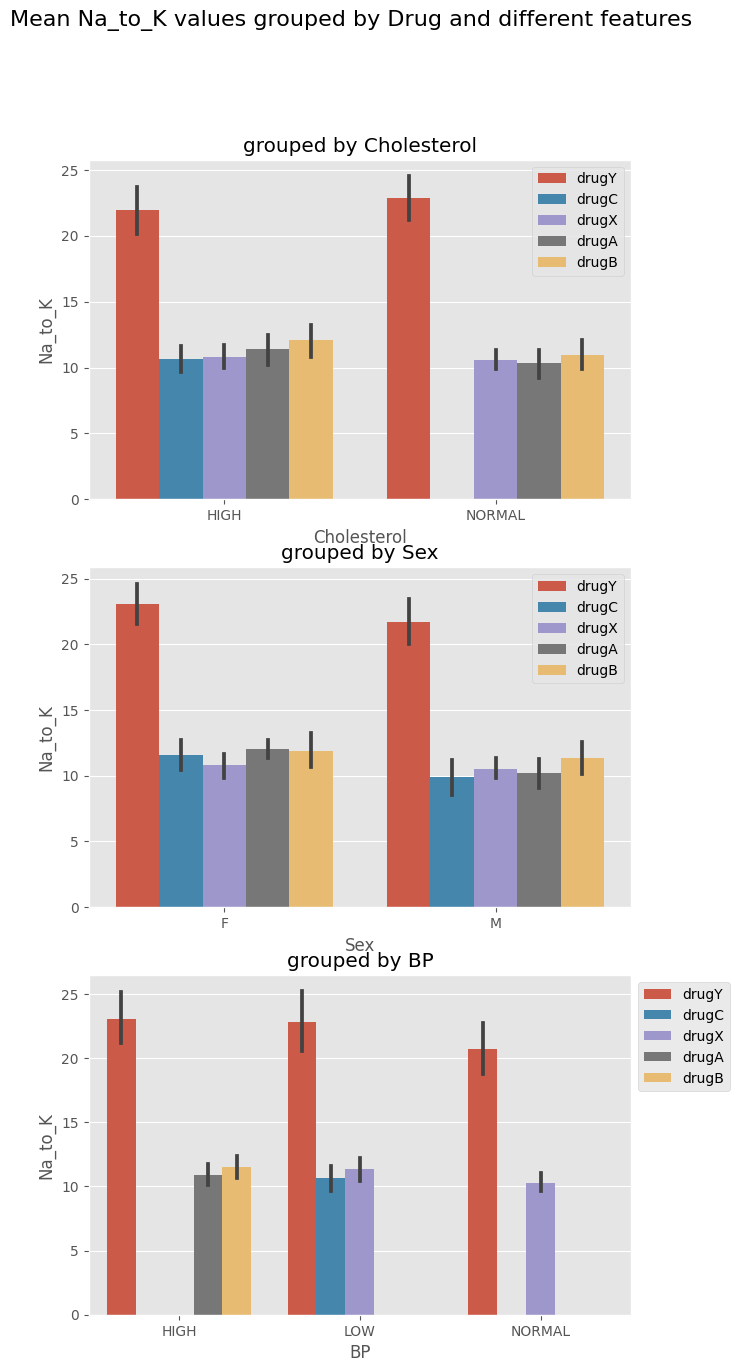

In [118]:
# Mean Na_to_K values grouped by Drug and different features
fig,ax = plt.subplots(3,1,figsize = (7,15))

sns.barplot(x=df["Cholesterol"],y=df["Na_to_K"],hue=df["Drug"],ax=ax[0])
ax[0].legend(bbox_to_anchor=(1, 1))
ax[0].title.set_text("grouped by Cholesterol")

sns.barplot(x=df["Sex"],y=df["Na_to_K"],hue=df["Drug"],ax=ax[1])
ax[1].legend(bbox_to_anchor=(1, 1))
ax[1].title.set_text("grouped by Sex")

sns.barplot(x=df["BP"],y=df["Na_to_K"],hue=df["Drug"],ax=ax[2])
ax[2].legend(bbox_to_anchor=(1, 1))
ax[2].title.set_text("grouped by BP")

fig.suptitle("Mean Na_to_K values grouped by Drug and different features", fontsize=16) 


plt.show()

Here also grouping by different categorical features did not give any effect on the mean values of Na_to_K compared to previously not grouped distribution.

#### Summary for EDA
- Age: Age value for drugB is outstandingly high, distribution for the rest of drugs is generally overlaping, it's predictive power is yet to be tested.
- Na_to_K: value for drugY is outstandingly high, distribution for the rest of drugs is generally overlaping, it's predictive power is yet to be tested.
- Sex: Sex does not affect target variable.
- BP: BP shows clear and strong effect on the distribution of some drugs, it's probably good for predictions.
- Cholesterol: Cholesterol shows effect on the distribution of some drugs, it's probably good for predictions.

<a id='model_development'></a>
### 4. Model Development

In this section different Naive Bayes and SVM models will be build and evaluated. The goal is to test what will perfrom better on this tiny dataset, very simple or very complex model.

<p><strong><span style="color: red;">Disclaimer:</span></strong> Please note that the model has been trained on a small, synthetic dataset that was designed specifically for predictive purposes. The limited volume of data may potentially lead to overfitting. In this specific context (i.e., a dataset specifically designed for predictions and the small size of the dataset), such overfitting could result in overly optimistic performance metrics. Consequently, any findings or results should be interpreted with caution.</p>


<a id='data_preparation'></a>
#### 4.1. Data preparation 

First the data needs to be properly encoded and scaled and then split into training and testing set, keeping in mind data leakage.

In [119]:
# one more look at the data
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [120]:
# shape
df.shape

(200, 6)

Based on what is known about the data:
- Sex: will be rejected from the features
- BP and Cholesterol: will be One-hot Encoded, not Ordinal Encoded, because these features despite being ordinal as suggested by class names, they dont show any ordinal/linear pattern, the pattern they show is more complex so it's better not to "confuse" model traning with some aranged order in this case.
- Age and Na_to_K: will be scaled using normalization because it will match One-hot Encoding of categorcial features, then all feature will range from 0 to 1 which is consistant.
- Drug (target): target will be encoded using LabelEncoding, scikit-learn can handle label encoding even if the algorithm works using One vs Rest method, it will handle all necessary transformations itself.

First, the data needs to be split into a training set and a testing set. Then, a transformer is trained using the training data, and its transformations are subsequently applied to both the training and testing sets. This step helps to avoid data leakage, which can occur if the transformer is trained on the entire dataset.

In [121]:
# in case of drawing new conclusions or need to have data not preprocessed yet a copy of original DataFrame will be made
# so the original is untouched
data = df.copy()

In [122]:
# drop the Sex feature
data.drop(columns="Sex",inplace=True)

In [123]:
# holdout dataset, for final evaluation
holdout = data.sample(20,random_state=1)
data.drop(index=holdout.index,inplace=True)

# feature-target split
holdout_X = holdout.iloc[:,:-1]
holdout_y = holdout["Drug"]

In [124]:
# spliting the data into features and target
data_X = data.iloc[:,:-1]
data_y = data["Drug"]

In [125]:
# in case of target variable, there is no such concept as data leakage when making transformations, so it can encoded now
target_encoder = LabelEncoder()
data_y = target_encoder.fit_transform(data_y)

# and the holdout set target
holdout_y = target_encoder.transform(holdout_y)

In [126]:
# train-test split
train_X, test_X, train_y, test_y = train_test_split(data_X,data_y,test_size=0.2,random_state=1)

Due to the small size of the dataset, the size of the testing data was set to only 20% of the original dataset.

In [127]:
# preparing column transformer for the features, it will perform One-hot Encoding and standarization
transformer = make_column_transformer((StandardScaler(),["Age","Na_to_K"]),(OneHotEncoder(),["BP","Cholesterol"]))

In [128]:
# fitting the transformer based on train_X data and transforming given data in one go
train_X = transformer.fit_transform(train_X)

In [129]:
# transforming the test data
test_X = transformer.transform(test_X)

<a id='support_vector_machine'></a>
#### 4.2. Support Vector Machine

In [130]:
# hyperparameters of default model are kernel = Radial basis function and regularization (C) = 1
svm_default = SVC(probability=True,random_state=1)
svm_default.fit(train_X,train_y);

In [131]:
# predictions using default SVM
svm_default_predictions = svm_default.predict(test_X)
# probability
svm_default_proba = svm_default.predict_proba(test_X)

In [132]:
# custom evaluation function
def report(y_true,y_pred,proba):
    fig,ax = plt.subplots(1,2,figsize=(12,4))
    
    auc_scores = []
    
    for x in range(len(data["Drug"].unique())):
        y_class = np.where(y_true == x, 1, 0)
        auc_scores.append(roc_auc_score(y_class,proba[:,x]))
        
    

    print(f"Accuracy = {accuracy_score(y_true,y_pred)}")
    print()
    individual_class_score = {
        "Recall":recall_score(y_true,y_pred,average=None),
        "Precision":precision_score(y_true,y_pred,average=None),
        "F1":f1_score(y_true,y_pred,average=None), 
        "AUC":auc_scores
    }
    
    print("class (row) x test score (column)")
    print()
    print(pd.DataFrame(individual_class_score))
    
    print()
    
    print("Summary:")
    print(f"Recall = {recall_score(y_true,y_pred,average='macro')}")
    print(f"Precision = {precision_score(y_true,y_pred,average='macro')}")
    print(f"F1 = {f1_score(y_true,y_pred,average='macro')}")
    print(f"AUC = {roc_auc_score(y_true,proba,average='macro',multi_class='ovr')}")
    
    
    sns.heatmap(confusion_matrix(y_true,y_pred),ax=ax[0],annot=True)
    ax[0].set_xlabel("Predicted values")
    ax[0].set_ylabel("Actual values")
    ax[0].title.set_text("Confusion matrix")
    
    ax[1].plot([0,1],[0,1])
    
    for x in range(len(data["Drug"].unique())):
        y_class = np.where(y_true == x, 1, 0)
        roc_curve_ = roc_curve(y_class,proba[:,x])
        ax[1].plot(roc_curve_[0],roc_curve_[1],label=f"Class:{x}")
        
    ax[1].legend()  
    ax[1].title.set_text("ROC curve")
    ax[1].set_xlabel("False positive rate")
    ax[1].set_ylabel("True positive rate")
    
    
    

Accuracy = 0.9444444444444444

class (row) x test score (column)

   Recall  Precision        F1       AUC
0    1.00   0.666667  0.800000  1.000000
1    0.75   1.000000  0.857143  0.992188
2    1.00   1.000000  1.000000  1.000000
3    1.00   0.875000  0.933333  1.000000
4    0.95   1.000000  0.974359  1.000000

Summary:
Recall = 0.9400000000000001
Precision = 0.9083333333333332
F1 = 0.912967032967033
AUC = 0.9984375


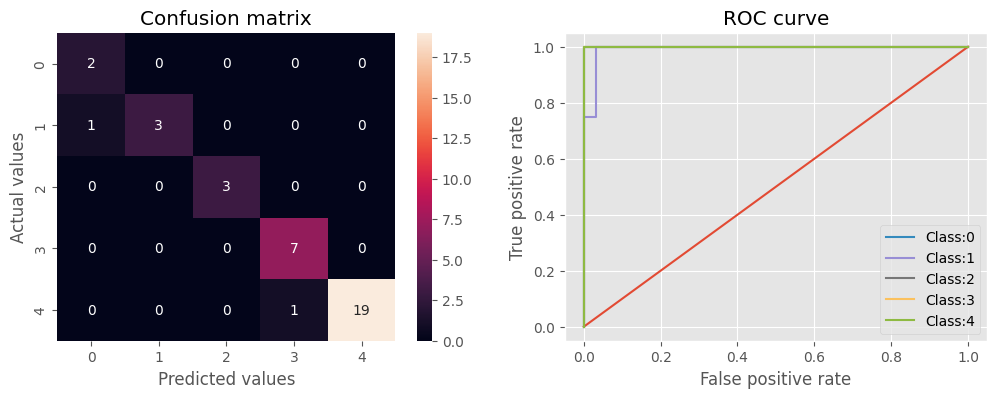

In [133]:
# predictions validation report
report(test_y,svm_default_predictions,svm_default_proba)

Looking at statistics, default SVM model does a very good job on validation data, now it's time for evaluation on the holdout set.

In [134]:
# now SVM and transformer will be fitted using whole dataset, this is common approach before model deployment
svm_default.fit(transformer.fit_transform(data_X),data_y)

SVC(probability=True, random_state=1)

In [135]:
# holdout features transformed using transformer fitted with trainig+testing data
default_svm_holdout_X = transformer.transform(holdout_X)

In [136]:
# making predictions on holdout dataset
svm_default_holdout_pred = svm_default.predict(default_svm_holdout_X)
svm_default_holdout_proba = svm_default.predict_proba(default_svm_holdout_X)

Accuracy = 0.95

class (row) x test score (column)

     Recall  Precision        F1  AUC
0  1.000000   1.000000  1.000000  1.0
1  1.000000   1.000000  1.000000  1.0
2  1.000000   1.000000  1.000000  1.0
3  0.857143   1.000000  0.923077  1.0
4  1.000000   0.888889  0.941176  1.0

Summary:
Recall = 0.9714285714285715
Precision = 0.9777777777777779
F1 = 0.9728506787330315
AUC = 1.0


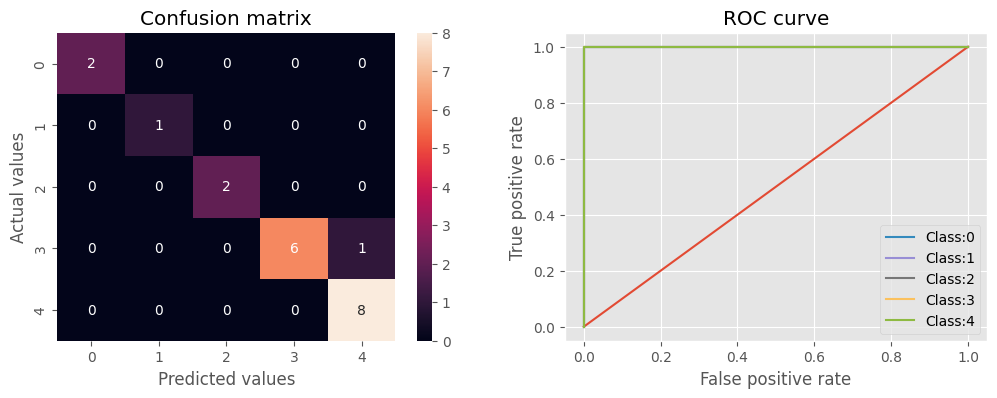

In [137]:
# evaluation report of predictions made
report(holdout_y,svm_default_holdout_pred,svm_default_holdout_proba)

Default SVM model still proves to be very well performing even on holdout dataset.

In [138]:
# Support Vector Machine hyperparameter tuning

# the previous transformer and estimator constructor are just copied
# using pipeline for GridSearchCV can assure that data will be transformed based on CV splits, and there will be no leakage
svc_pipeline = make_pipeline(clone(transformer),clone(svm_default))

In [139]:
# Support Vector Machine hyperparameters to test
svm_hyperparameters = [{"svc__C":[0.01,0.1,1.0,10,100,1000],"svc__gamma":[0.1, 1, 10,"auto","scale"],
                        "svc__kernel":["rbf","sigmoid"]},
                      {"svc__C":[0.01,0.1,1.0,10,100,1000],"svc__kernel":["linear"]},
                      {"svc__C":[0.01,0.1,1.0,10,100,1000],"svc__kernel":["poly"],"svc__gamma":[0.1, 1, 10,"auto","scale"],
                      "svc__degree":[2,3,4,5,6]}]

In [140]:
# GridSearchCV object for SVM and hyperparamters above
svc_pipeline_gridsearch = GridSearchCV(svc_pipeline, svm_hyperparameters,cv=10, scoring=["accuracy","recall_macro",
                                         "precision_macro","f1_macro"],refit="accuracy",n_jobs=-1)

In [141]:
# searching for best hyperparameters
svc_pipeline_gridsearch.fit(data_X,data_y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Na_to_K']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['BP',
                                                                          'Cholesterol'])])),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=1))]),
             n_jobs=-1,
             param

In [142]:
# best SVM model
pd.DataFrame(svc_pipeline_gridsearch.cv_results_).loc[svc_pipeline_gridsearch.best_index_,["mean_test_accuracy",
                                                "mean_test_recall_macro", "mean_test_precision_macro", "mean_test_f1_macro"]]

mean_test_accuracy           0.977778
mean_test_recall_macro         0.9635
mean_test_precision_macro    0.959111
mean_test_f1_macro           0.960215
Name: 30, dtype: object

In [143]:
svc_pipeline_gridsearch.best_score_

0.9777777777777779

In [144]:
# best hyperparamters
svc_pipeline_gridsearch.best_params_

{'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

Tuned SVM model is even more accurate and has higher statstics than default one, based on cross-validation results. Now it's time for the holdout dataset evaluation.

In [145]:
# extracting best model from GridSearchCV instance
svm_tuned = svc_pipeline_gridsearch.best_estimator_

In [146]:
# predictions on holdout dataset
svm_tuned_holdout_pred = svm_tuned.predict(holdout_X)
svm_tuned_holdout_proba = svm_tuned.predict_proba(holdout_X)

Accuracy = 1.0

class (row) x test score (column)

   Recall  Precision   F1  AUC
0     1.0        1.0  1.0  1.0
1     1.0        1.0  1.0  1.0
2     1.0        1.0  1.0  1.0
3     1.0        1.0  1.0  1.0
4     1.0        1.0  1.0  1.0

Summary:
Recall = 1.0
Precision = 1.0
F1 = 1.0
AUC = 1.0


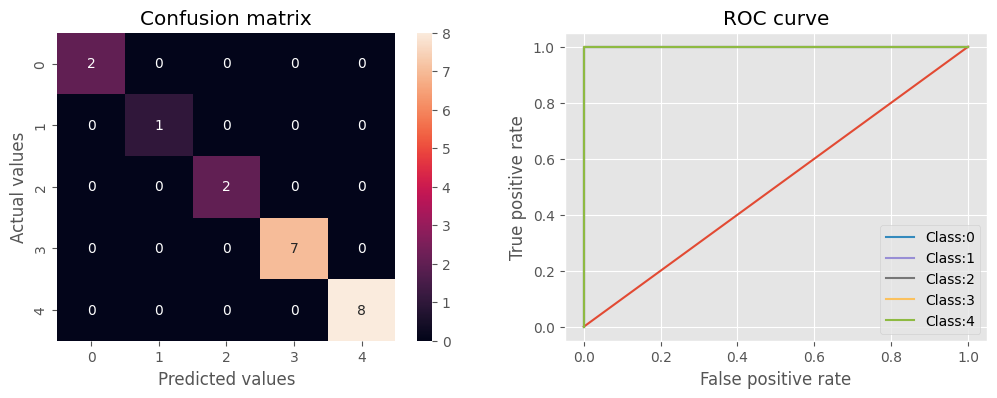

In [147]:
# evaluation of tuned SVM
report(holdout_y,svm_tuned_holdout_pred,svm_tuned_holdout_proba)

The tuned SVM model achieved perfect accuracy and perfect other statistics. However, this result must be interpreted with caution due to the small size of the dataset and the even smaller holdout set. The limited data may have contributed to an overfit model, and the model's performance may not generalize well to new, unseen data. Given that the holdout set is extremely small (20 samples), there's a possibility that the perfect classification could simply be due to a lucky sample.

Support Vector Machines (SVMs) have performed exceptionally well in our predictions. As mentioned earlier, this might be due to issues with the dataset. However, SVMs are known to work well with small datasets due to their ability to generalize data and identify complex patterns, making them particularly robust in such cases. For comparison, we will also use a Naive Bayes model, which is a simpler algorithm and is typically more suited to larger datasets. This comparison should help us better determine whether the outstanding performance of the SVM is due to its suitability for this specific problem or if there are potential issues with the dataset.

<a id='naive_bayes'></a>
#### 4.2. Naive Bayes

Two Naive Bayes algorithms will be used: Gaussian Naive Bayes and Multinomial Naive Bayes. The Gaussian Naive Bayes algorithm is suitable for continuous data that is normally distributed, while the Multinomial Naive Bayes algorithm works with categorical and discrete data. In the currently used dataset, there is a mixture of these data types. The approach I will take is to include all encoded and scaled features, including categorical ones, for the Gaussian version. With such small dataset, rejecting half of features is not affordable. For the Multinomial version, continuous features will be binned to treat them as categorical data.

So, for Gaussian Naive Bayes features will be encoded and scaled in the same way as previously, and for Multinomial version, new transformations are required.

<a id='gaussian_bayes'></a>
##### 4.2.1 Gaussian Naive Bayes 

A copy of the previous transformer can be used because categorical features still need to be encoded. Although scaling is not necessary for Gaussian Naive Bayes, it is not a problem to perform it. If the transformer being used includes scaling, there is no need to make any changes.

In [148]:
# this time default model has no _default sufix, because such simple algorithm most often does not require any tuning
gaussiannb = GaussianNB()

In [149]:
# firstly, it's performance will be tested using previous train-test split

# training the model
gaussiannb.fit(train_X,train_y)

# making predictions
gaussiannb_pred = gaussiannb.predict(test_X)
gaussiannb_prob = gaussiannb.predict_proba(test_X)

Accuracy = 0.6388888888888888

class (row) x test score (column)

   Recall  Precision        F1       AUC
0    1.00   0.333333  0.500000  0.970588
1    0.75   0.750000  0.750000  0.976562
2    1.00   0.500000  0.666667  1.000000
3    1.00   0.583333  0.736842  0.990148
4    0.40   1.000000  0.571429  0.862500

Summary:
Recall = 0.8300000000000001
Precision = 0.6333333333333333
F1 = 0.6449874686716792
AUC = 0.9599597037090698


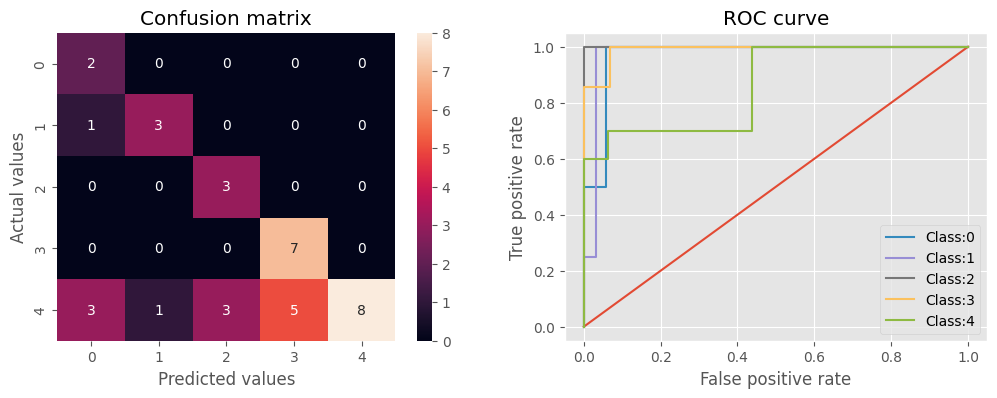

In [150]:
# evaluation report
report(test_y,gaussiannb_pred,gaussiannb_prob)

Very poor performance of Gaussian NB compared to SVM models, especially for the target class 4. I have three thoeries why it might be: 
1. During the exploratory data analysis, it was noticed that the features in the data set didn't have strong predictive power. While complex models like Support Vector Machines (SVMs) can sometimes handle such situations effectively, simpler models like Gaussian Naive Bayes may struggle.
2. The target class in our data was significantly imbalanced. One class, 'drugY', was oversampled, which impacted the probability estimations in the Gaussian Naive Bayes model. For instance, a certain feature appearing once in a class with only three instances corresponds to a high probability (33%), while the same feature appearing ten times in the oversampled 'drugY' class with, say, a hundred instances, corresponds to a much lower probability (10%). This discrepancy was exacerbated by the lack of strongly distinguishing features between the target classes. This still might be strange because prior probability should balance out such scenarios.
3. Furthermore, the dataset included categorical features. While these can be accommodated by some versions of Naive Bayes, they aren't ideal for Gaussian Naive Bayes, which assumes a Gaussian (normal) distribution of data.

Despite small amount of features, maybe it's worth to reject categorical ones and try again.

In [151]:
# remainder how the features looked like before transformations
data_X.head(3)

,Age,BP,Cholesterol,Na_to_K
0,23,HIGH,HIGH,25.355
1,47,LOW,HIGH,13.093
2,47,LOW,HIGH,10.114


In [152]:
# preprocessing for Gaussian NB purposes
gaussian_data_X = data_X.drop(columns=["BP","Cholesterol"])

In [153]:
# as mentioned above in case of Naive Bayes, the data does not require scaling
gaussian_data_X.head()

,Age,Na_to_K
0,23,25.355
1,47,13.093
2,47,10.114
3,28,7.798
5,22,8.607


In [154]:
# previously random_state was set to 1, thanks to that, exact same split can be achived
g_train_X, g_test_X, g_train_y, g_test_y = train_test_split(gaussian_data_X,data_y,test_size=0.2,random_state=1)

In [155]:
# new instance
new_gaussiannb = GaussianNB()

In [156]:
# train the model
new_gaussiannb.fit(g_train_X,g_train_y)

# making predictions
new_gaussiannb_pred = new_gaussiannb.predict(g_test_X)
new_gaussiannb_prob = new_gaussiannb.predict_proba(g_test_X)

Accuracy = 0.6944444444444444

class (row) x test score (column)

     Recall  Precision        F1       AUC
0  0.000000       0.00  0.000000  0.838235
1  0.250000       0.25  0.250000  0.843750
2  0.000000       0.00  0.000000  0.656566
3  0.571429       0.40  0.470588  0.793103
4  1.000000       1.00  1.000000  1.000000

Summary:
Recall = 0.36428571428571427
Precision = 0.32999999999999996
F1 = 0.34411764705882353
AUC = 0.8263308797918331


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


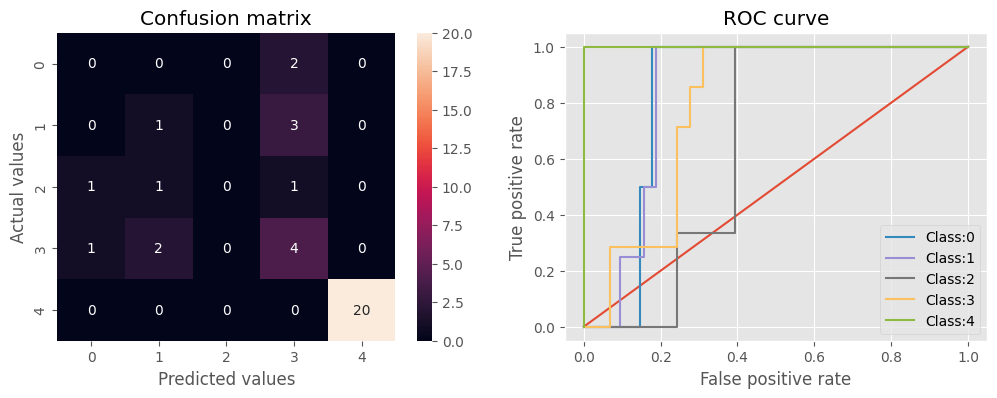

In [157]:
# evaluation report
report(test_y,new_gaussiannb_pred,new_gaussiannb_prob)

Now results are just tragic. Now the prior probability, probably made huge bias towards majority class.

Predictions on holdout set will be made using the previous model of GaussianNB which included all features.

In [158]:
# refit the model with traini+testin data
gaussiannb.fit(transformer.fit_transform(data_X),data_y)

GaussianNB()

In [159]:
# transfrom holdout features accordingly to training features
gaussiannb_holdout_X = transformer.transform(holdout_X)

In [160]:
# make predictions 
holdout_gaussiannb_pred = gaussiannb.predict(gaussiannb_holdout_X)
holdout_gaussiannb_proba = gaussiannb.predict_proba(gaussiannb_holdout_X)

Accuracy = 0.7

class (row) x test score (column)

   Recall  Precision        F1       AUC
0    1.00   0.500000  0.666667  0.944444
1    1.00   1.000000  1.000000  1.000000
2    1.00   0.500000  0.666667  0.944444
3    1.00   0.777778  0.875000  1.000000
4    0.25   1.000000  0.400000  0.645833

Summary:
Recall = 0.85
Precision = 0.7555555555555555
F1 = 0.7216666666666666
AUC = 0.9069444444444444


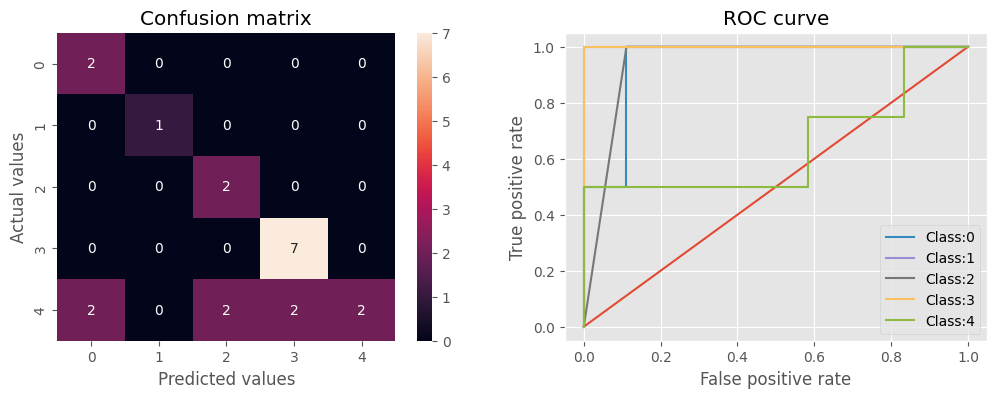

In [161]:
# evaluation report
report(holdout_y,holdout_gaussiannb_pred,holdout_gaussiannb_proba)

Compared to SVM models, it is bad. The holdout dataset confirms that the model strugles with class 4 predictions.

<a id='multi_bayes'></a>
##### 4.2.2 Multinomial Naive Bayes 

For Multinomial NB, data requires different preprocessing. Continuous values will be bined, so they act as discrete values. Also there is no need for scaling, only encoding.

In [162]:
# transformer bining the continuous values and encoding all features using ordinal encoding
multinomial_transformer = make_column_transformer((KBinsDiscretizer(encode="ordinal", strategy="uniform",n_bins=10),
                        ["Age","Na_to_K"]),(OrdinalEncoder(),["BP","Cholesterol"]))

In [163]:
# again, achiving same train-test split
m_train_X, m_test_X, m_train_y, m_test_y = train_test_split(data_X,data_y,test_size=0.2,random_state=1)

In [164]:
# transform train and test features
m_train_X = multinomial_transformer.fit_transform(m_train_X)
m_test_X = multinomial_transformer.transform(m_test_X)

In [165]:
# instantiating the Multinomial NB class
multinomialnb = MultinomialNB()

In [166]:
# fit the model
multinomialnb.fit(m_train_X,m_train_y)

MultinomialNB()

In [167]:
# make predictions
multinomial_pred = multinomialnb.predict(m_test_X)
multinomial_prob = multinomialnb.predict_proba(m_test_X)

Accuracy = 0.7222222222222222

class (row) x test score (column)

     Recall  Precision        F1       AUC
0  0.500000   0.250000  0.333333  0.794118
1  0.500000   1.000000  0.666667  1.000000
2  0.000000   0.000000  0.000000  0.828283
3  0.857143   0.666667  0.750000  0.970443
4  0.850000   0.850000  0.850000  0.928125

Summary:
Recall = 0.5414285714285715
Precision = 0.5533333333333333
F1 = 0.52
AUC = 0.9041937650190691


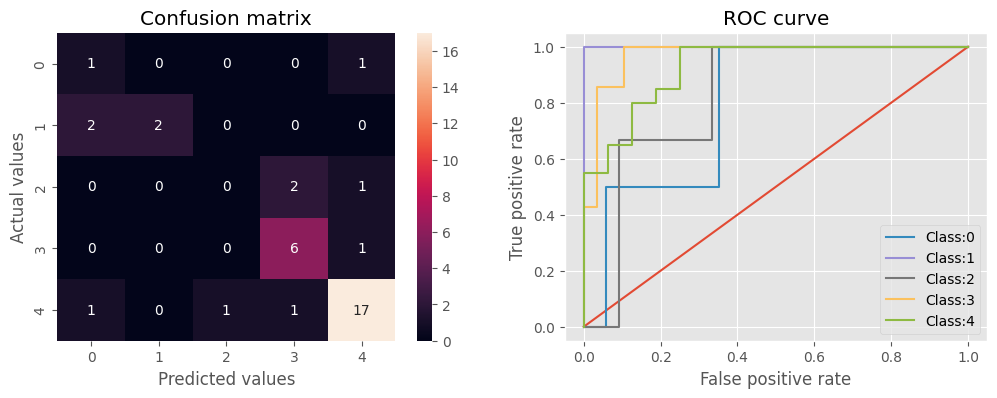

In [168]:
# train-test split predictions evaluation
report(m_test_y,multinomial_pred,multinomial_prob)

Still compared to SVM models, results are not satisfactory. The model could not make any correct prediction for class 2. The best predictions were made for class 3 and the recall and precision for the rest of classes is just poor.  

Overall, Multinomial Naive Bayes performed the best on the train-test split. However, I believe that further improvement is possible. While there are not many hyperparameters to tune, combining them with cross-validation may yield better results.

In [178]:
# preparing hyperparameters to test
multinomial_hyperparamters = {"multinomialnb__alpha":[0.001,0.1,0.5,1,2,10,100],"multinomialnb__fit_prior":[True,False]}

In [179]:
# transformer and classifier pipeline
multinomial_pipeline = make_pipeline(clone(multinomial_transformer),clone(multinomialnb))

In [180]:
# set the grid search
multinomial_pipeline_gridsearch = GridSearchCV(multinomial_pipeline,param_grid=multinomial_hyperparamters,
                            scoring=["accuracy","recall_macro","precision_macro","f1_macro"],refit="accuracy",n_jobs=-1)

In [181]:
# run the grid search
multinomial_pipeline_gridsearch.fit(data_X,data_y)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('kbinsdiscretizer',
                                                                         KBinsDiscretizer(encode='ordinal',
                                                                                          n_bins=10,
                                                                                          strategy='uniform'),
                                                                         ['Age',
                                                                          'Na_to_K']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(),
                                                                         ['BP',
                                                                          'Cholesterol'])])),
  

In [182]:
# results of best model
pd.DataFrame(multinomial_pipeline_gridsearch.cv_results_).loc[multinomial_pipeline_gridsearch.best_index_,["mean_test_accuracy",
                                                "mean_test_recall_macro", "mean_test_precision_macro", "mean_test_f1_macro"]]

mean_test_accuracy           0.744444
mean_test_recall_macro       0.531016
mean_test_precision_macro    0.449568
mean_test_f1_macro           0.479431
Name: 10, dtype: object

In [183]:
multinomial_pipeline_gridsearch.best_score_

0.7444444444444445

In [184]:
# best hyperparameters found
multinomial_pipeline_gridsearch.best_params_

{'multinomialnb__alpha': 10, 'multinomialnb__fit_prior': True}

Maybe now the best model found shows worse statistics than basic model, but they were not evaluated in same way. The first one was evaluated using train-test split, and this was evaluated using cross-validation. Now the best GridSearchCV model will be refit only with training data and evaluated using testing split.

In [194]:
# again same split needs to be made, because previous splits are already transformed
m_train_X, m_test_X, m_train_y, m_test_y = train_test_split(data_X,data_y,test_size=0.2,random_state=1)

In [195]:
# extract the best classifier from GridSearchCv
tuned_multinomialnb = multinomial_pipeline_gridsearch.best_estimator_

# fit the best classifier
tuned_multinomialnb.fit(m_train_X,m_train_y)

# make predictions
tuned_multinomialnb_pred = tuned_multinomialnb.predict(m_test_X)
tuned_multinomialnb_proba = tuned_multinomialnb.predict_proba(m_test_X)

Accuracy = 0.8055555555555556

class (row) x test score (column)

     Recall  Precision        F1       AUC
0  0.500000   1.000000  0.666667  0.720588
1  1.000000   1.000000  1.000000  1.000000
2  0.000000   0.000000  0.000000  0.666667
3  0.857143   0.600000  0.705882  0.955665
4  0.900000   0.857143  0.878049  0.937500

Summary:
Recall = 0.6514285714285715
Precision = 0.6914285714285715
F1 = 0.6501195600191295
AUC = 0.8560839853182654


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


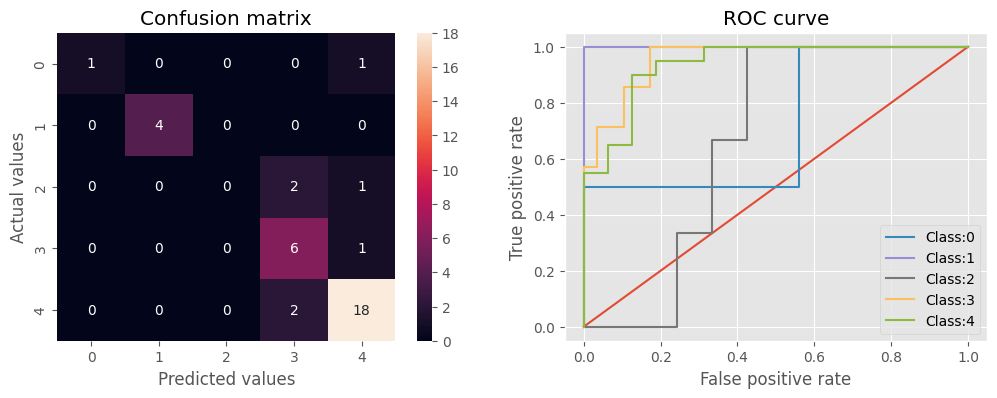

In [196]:
# train-test evaluation report
report(m_test_y,tuned_multinomialnb_pred,tuned_multinomialnb_proba)

The results are better than these for the default model, hence this model will be used for holdout evaluation.

In [198]:
# refit the model using whole data
tuned_multinomialnb.fit(data_X,data_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('kbinsdiscretizer',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=10,
                                                                   strategy='uniform'),
                                                  ['Age', 'Na_to_K']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['BP', 'Cholesterol'])])),
                ('multinomialnb', MultinomialNB(alpha=10))])

In [201]:
# holdout predictions
holdout_tuned_multinomialnb_pred =  tuned_multinomialnb.predict(holdout_X)
holdout_tuned_multinomialnb_prob =  tuned_multinomialnb.predict_proba(holdout_X)

Accuracy = 0.7

class (row) x test score (column)

     Recall  Precision        F1       AUC
0  0.000000   0.000000  0.000000  0.805556
1  1.000000   1.000000  1.000000  1.000000
2  0.000000   0.000000  0.000000  0.472222
3  0.714286   0.714286  0.714286  0.912088
4  1.000000   0.666667  0.800000  0.947917

Summary:
Recall = 0.5428571428571429
Precision = 0.47619047619047616
F1 = 0.5028571428571429
AUC = 0.8275564713064713


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


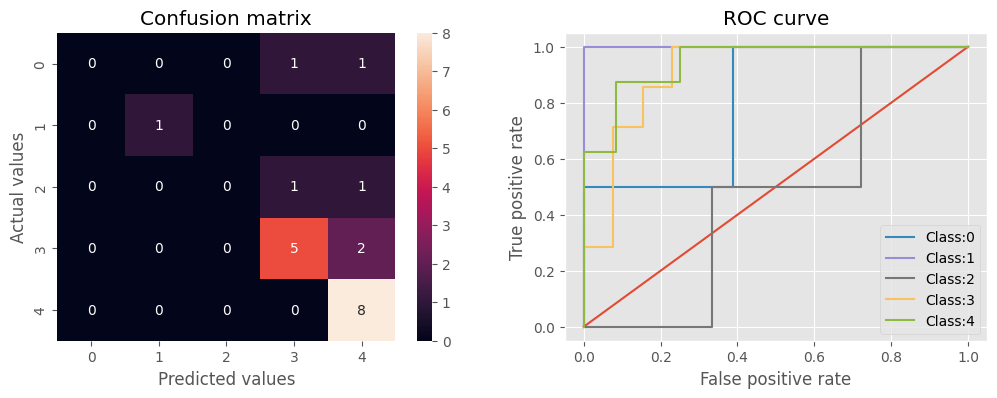

In [202]:
report(holdout_y,holdout_tuned_multinomialnb_pred,holdout_tuned_multinomialnb_prob)

<a id='conclusion'></a>
### Results and Conclusion

The drug classification dataset presented a substantial challenge to manipulate. The limited quantity of samples, together with a meager set of features possessing minimal predictive power, significantly impeded our progress. Further complications arose due to a pronounced imbalance within the target classes, and the multiclass nature of the problem only amplified the difficulty.

During the Exploratory Data Analysis stage, a meticulous, in-depth examination of each feature was necessary to assess its potential contribution to prediction accuracy. The complex nature of the dataset took a toll on Naive Bayes models, which follow a relatively straightforward methodology. Hindered by the complex attributes and limitations of the features, these models often ended up either overfitting or struggling to differentiate between target classes.

Conversely, more complex models such as Support Vector Machines (SVM) proved remarkably effective in this demanding context. The high accuracy achieved by the SVM models was initially suspicious, leading me to question the possibility of the dataset being artificially easy for prediction. However, the difficulties experienced by the Naive Bayes models negated this hypothesis.

The SVM models also exhibited impressive performance on both validation and holdout sets. In light of these findings, it seems that SVM models tend to be more effective in tackling complex problems of this nature.